In [1]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import pearsonr
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
# basic EDA of microarray expression data
file_expression = pd.read_csv("../ADNI_download/ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile.csv",header=None, index_col=0) #, dtype={'INDEX':str})
file_expression.describe()

,1,2,3,4,5,6,7,8,9,10,...,738,739,740,741,742,743,744,745,746,747
count,43789,48158,49394.000,49394.000,49394.00,49394.000,49394.000,49394.000,49394.000,49394.000,...,49394.000,49394.00,49394.000,49394.00,49394.000,49394.00,49394.00,49394.000,49394.000,49386
unique,18725,20093,10122.000,10181.000,10157.00,10123.000,10128.000,10099.000,10154.000,10161.000,...,10139.000,10087.00,10153.000,10118.00,10196.000,10158.00,10118.00,10122.000,10135.000,23398
top,LOC4763,NF1,2.269,2.129,2.27,2.288,2.293,2.377,2.191,2.481,...,2.096,2.46,2.189,2.23,2.457,2.38,2.13,2.491,2.368,{NO TARGETS}
freq,16,19,111.000,123.000,84.00,93.000,88.000,120.000,142.000,97.000,...,113.000,103.00,122.000,108.00,59.000,109.00,120.00,119.000,109.000,23


In [3]:
file_expression.head(20)

,1,2,3,4,5,6,7,8,9,10,...,738,739,740,741,742,743,744,745,746,747
0,,,,,,,,,,,,,,,,,,,,,
Phase,NaN,NaN,ADNIGO,ADNI2,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNIGO,...,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNI2,NaN
Visit,NaN,NaN,m48,v03,v03,m48,v03,v03,v06,bl,...,bl,v03,m60,v03,bl,v03,v03,v03,v06,NaN
SubjectID,NaN,NaN,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,NaN
260/280,NaN,NaN,2.05,2.07,2.04,2.03,2.01,2.05,1.95,1.99,...,2.05,2.05,1.98,2.09,1.87,2.03,2.11,1.94,2.06,NaN
260/230,NaN,NaN,0.55,1.54,2.1,1.52,1.6,1.91,1.47,2.07,...,1.9,2.05,1.65,1.56,1.45,1.33,0.27,1.72,1.35,NaN
RIN,NaN,NaN,7.7,7.6,7.2,6.8,7.9,7,7.9,7.2,...,6.7,6.5,6.3,6.4,6.6,6.8,6.2,5.8,6.7,NaN
Affy Plate,NaN,NaN,7,3,6,7,9,4,3,8,...,8,6,9,3,8,5,3,1,4,NaN
YearofCollection,NaN,NaN,2011,2012,2011,2011,2011,2012,2011,2011,...,2011,2012,2011,2012,2011,2012,2011,2011,2012,NaN
ProbeSet,LocusLink,Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## Set column names
col_names = file_expression.loc['SubjectID']
col_names[0:2]=['LocusLink','Symbol']
col_names

1       LocusLink
2          Symbol
3      116_S_1249
4      037_S_4410
5      006_S_4153
6      116_S_1232
7      099_S_4205
8      007_S_4467
9      128_S_0205
10     003_S_2374
11     036_S_4491
12     098_S_4059
13     031_S_2018
14     002_S_4654
15     019_S_4285
16     141_S_4426
17     067_S_4072
18     037_S_4308
19     041_S_4200
20     128_S_0200
21     129_S_4220
22     018_S_4313
23     067_S_0257
24     029_S_1218
25     141_S_4053
26     136_S_4408
27     021_S_2142
28     114_S_4404
29     116_S_4167
30     116_S_4209
          ...    
718    131_S_0384
719    135_S_4309
720    129_S_4369
721    137_S_0686
722    128_S_4571
723    099_S_2063
724    011_S_4120
725    041_S_0125
726    053_S_2357
727    137_S_0973
728    021_S_0984
729    027_S_0116
730    052_S_0951
731    014_S_4401
732    036_S_4562
733    137_S_0459
734    018_S_4696
735    023_S_4164
736    128_S_2130
737    082_S_4339
738    022_S_2379
739    014_S_4668
740    130_S_0289
741    141_S_4456
742    009

In [5]:
file_expression.columns = list(col_names)
file_expression.head()

,LocusLink,Symbol,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,nan
0,,,,,,,,,,,,,,,,,,,,,
Phase,NaN,NaN,ADNIGO,ADNI2,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNIGO,...,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNI2,NaN
Visit,NaN,NaN,m48,v03,v03,m48,v03,v03,v06,bl,...,bl,v03,m60,v03,bl,v03,v03,v03,v06,NaN
SubjectID,LocusLink,Symbol,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,NaN
260/280,NaN,NaN,2.05,2.07,2.04,2.03,2.01,2.05,1.95,1.99,...,2.05,2.05,1.98,2.09,1.87,2.03,2.11,1.94,2.06,NaN
260/230,NaN,NaN,0.55,1.54,2.1,1.52,1.6,1.91,1.47,2.07,...,1.9,2.05,1.65,1.56,1.45,1.33,0.27,1.72,1.35,NaN


In [6]:
# Reformat the table for easy processing
transformed_table = file_expression
transformed_table = transformed_table.drop(['LocusLink','Symbol'],axis=1)
transformed_table = transformed_table.drop(transformed_table.columns[-1:],axis=1)
#transformed_table = transformed_table.drop(['SubjectID'])
transformed_table = transformed_table.T
transformed_table = transformed_table.rename(columns = {'SubjectID':'PTID'})
transformed_table.head()

,Phase,Visit,PTID,260/280,260/230,RIN,Affy Plate,YearofCollection,ProbeSet,11715100_at,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
116_S_1249,ADNIGO,m48,116_S_1249,2.05,0.55,7.7,7,2011,NaN,2.237,...,2.355,2.624,2.01,2.906,2.463,2.05,2.06,1.858,2.028,2.162
037_S_4410,ADNI2,v03,037_S_4410,2.07,1.54,7.6,3,2012,NaN,2.294,...,2.1,2.82,1.726,2.465,2.26,1.933,1.717,2.208,2.058,1.882
006_S_4153,ADNI2,v03,006_S_4153,2.04,2.1,7.2,6,2011,NaN,2.14,...,2.165,2.455,1.84,2.681,2.251,1.985,1.77,2.184,2.007,2.134
116_S_1232,ADNIGO,m48,116_S_1232,2.03,1.52,6.8,7,2011,NaN,2.062,...,2.094,2.599,1.837,2.713,2.158,1.916,1.878,2.163,2.185,2.099
099_S_4205,ADNI2,v03,099_S_4205,2.01,1.6,7.9,9,2011,NaN,2.04,...,1.973,2.544,1.909,2.548,2.266,2.077,1.838,2.085,1.941,1.883


In [7]:
transformed_table.describe()

,Phase,Visit,PTID,260/280,260/230,RIN,Affy Plate,YearofCollection,ProbeSet,11715100_at,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
count,744,744,744,744,744,744,744,744,0.0,744,...,744.000,744.00,744.000,744.000,744.000,744.000,744.000,744.000,744.000,744.000
unique,2,12,744,40,173,38,9,4,0.0,450,...,389.000,440.00,374.000,434.000,395.000,360.000,352.000,431.000,382.000,399.000
top,ADNI2,v03,018_S_2138,2.03,1.65,7.1,3,2011,NaN,2.435,...,2.181,2.71,1.828,2.613,2.337,1.983,1.849,2.262,1.925,2.125
freq,449,357,1,73,13,61,88,383,NaN,5,...,7.000,7.00,7.000,6.000,12.000,9.000,9.000,6.000,7.000,7.000


In [8]:
## Combine gene expression data with dream data
dream_data = pd.read_csv('../ADNI_download/AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/ADNI_Training_Q2_APOE_July22.2014.csv')
dream_data.head()

,RID,PTID,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2,APOE Genotype
0,5,011_S_0005,73.7,Male,16,0,29,115.0,1,"3,3"
1,19,067_S_0019,73.1,Female,18,0,29,260.0,0,"2,3"
2,31,023_S_0031,77.7,Female,18,0,30,240.0,0,"3,3"
3,43,018_S_0043,76.2,Male,16,0,29,175.0,1,"2,3"
4,47,100_S_0047,84.7,Male,20,0,30,252.0,0,"2,3"


In [9]:
dream_data.describe()

,RID,AGE,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,2543.375000,75.309091,16.255682,0.272727,29.028409,195.500000,0.460227
std,1874.399901,5.364692,2.600543,0.517737,1.239488,53.370559,0.499838
min,5.000000,62.000000,8.000000,0.000000,24.000000,75.000000,0.000000
25%,558.000000,71.775000,14.000000,0.000000,29.000000,149.950000,0.000000
50%,4032.500000,74.900000,16.000000,0.000000,29.000000,202.000000,0.000000
75%,4281.250000,78.400000,18.000000,0.000000,30.000000,240.000000,1.000000
max,4516.000000,89.600000,20.000000,2.000000,30.000000,302.800000,1.000000


In [10]:
data_common = pd.merge(left=dream_data, right=transformed_table, how='inner')
data_common = data_common.sort_values(by='ABETA')
data_common.head()

,RID,PTID,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2,APOE Genotype,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
40,984,021_S_0984,76.6,Male,14,1,30,75.0,1,"3,4",...,2.258,3.229,1.817,2.565,2.13,1.829,1.596,2.394,1.887,2.09
77,4179,033_S_4179,83.0,Male,20,2,30,82.7,1,"4,4",...,2.196,2.655,1.883,2.46,2.24,2.002,2.052,2.262,1.982,2.024
95,4339,082_S_4339,84.3,Male,17,2,29,90.7,1,"4,4",...,2.274,2.747,1.918,2.67,2.402,1.792,1.808,2.588,2.013,2.304
124,4474,031_S_4474,85.6,Male,18,0,28,92.5,1,"3,3",...,2.178,2.941,1.878,3.114,2.421,2.028,1.76,2.253,1.94,2.089
94,4335,021_S_4335,71.7,Female,15,0,30,95.4,1,"3,3",...,2.342,2.579,1.905,2.725,2.472,1.804,2.122,2.035,1.932,1.942


In [11]:
data_common.shape

(130, 49404)

In [12]:
data_common.columns[0:30]

Index(['RID', 'PTID', 'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'MMSE', 'ABETA',
       'SAGE.Q2', 'APOE Genotype', 'Phase', 'Visit', '260/280', '260/230',
       'RIN', 'Affy Plate', 'YearofCollection', 'ProbeSet', '11715100_at',
       '11715101_s_at', '11715102_x_at', '11715103_x_at', '11715104_s_at',
       '11715105_at', '11715106_x_at', '11715107_s_at', '11715108_x_at',
       '11715109_at', '11715110_at', '11715111_s_at'],
      dtype='object')

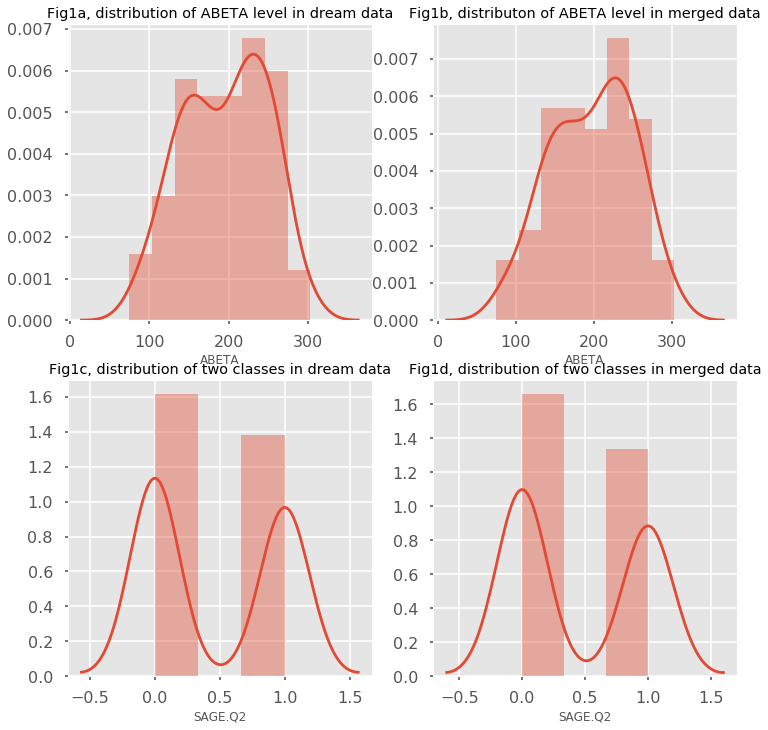

In [13]:
# Check distribution of amyloid-beta 42 level (ABETA) and class (SAGE.Q2)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
sns.distplot(dream_data['ABETA'], ax=axes[0,0])
axes[0,0].set_title("Fig1a, distribution of ABETA level in dream data")
sns.distplot(data_common['ABETA'], ax=axes[0,1])
axes[0,1].set_title("Fig1b, distributon of ABETA level in merged data")
sns.distplot(dream_data['SAGE.Q2'], ax=axes[1,0])
axes[1,0].set_title("Fig1c, distribution of two classes in dream data")
sns.distplot(data_common['SAGE.Q2'], ax=axes[1,1])
axes[1,1].set_title("Fig1d, distribution of two classes in merged data")



  agg_filter: unknown
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: [True | False] 
  axes: an :class:`~matplotlib.axes.Axes` instance 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  figure: a :class:`matplotlib.figure.Figure` instance 
  fontproperties or font_properties: a :class:`matplotlib.font_manager.FontProperties` instance 
  gid: an id string 
  horizontalalignment or ha: [ 'center' | 'right' | 'left' ] 
  label: string or anything printable with '%s' conversion. 
  linespacing: float (multiple of font size) 
  multialignment

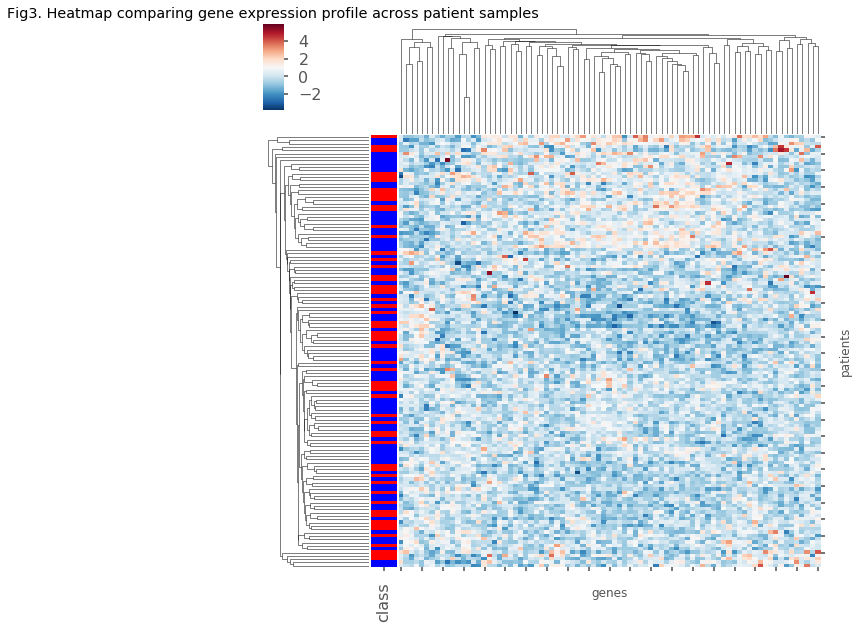

In [27]:
## Check gene expression profile difference by heatmap visualization
select_data = data_common[data_common.columns[19:100]]
select_data = select_data.convert_objects(convert_numeric=True)
select_data['class'] = data_common['SAGE.Q2']
exp_table = select_data.pop('class')
exp = dict(zip(exp_table.unique(), 'rbg'))
row_colors = exp_table.map(exp)
g = sns.clustermap(select_data, row_colors=row_colors, z_score=1, cmap="RdBu_r", mask=select_data.isnull());
plt.setp(g.ax_heatmap.set_yticklabels(''));
plt.setp(g.ax_heatmap.set_xticklabels(''));
plt.setp(g.ax_heatmap.set_xlabel('genes'));
plt.setp(g.ax_heatmap.set_ylabel('patients'));
plt.title("Fig3. Heatmap comparing gene expression profile across patient samples")
#sns.clustermap(select_data, row_colors=row_colors, z_score=0, annot=False, row_cluster=False, mask=select_data.isnull())

In [61]:
data_common.columns[0:30]

Index(['RID', 'PTID', 'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'MMSE', 'ABETA',
       'SAGE.Q2', 'APOE Genotype', 'Phase', 'Visit', '260/280', '260/230',
       'RIN', 'Affy Plate', 'YearofCollection', 'ProbeSet', '11715100_at',
       '11715101_s_at', '11715102_x_at', '11715103_x_at', '11715104_s_at',
       '11715105_at', '11715106_x_at', '11715107_s_at', '11715108_x_at',
       '11715109_at', '11715110_at', '11715111_s_at'],
      dtype='object')

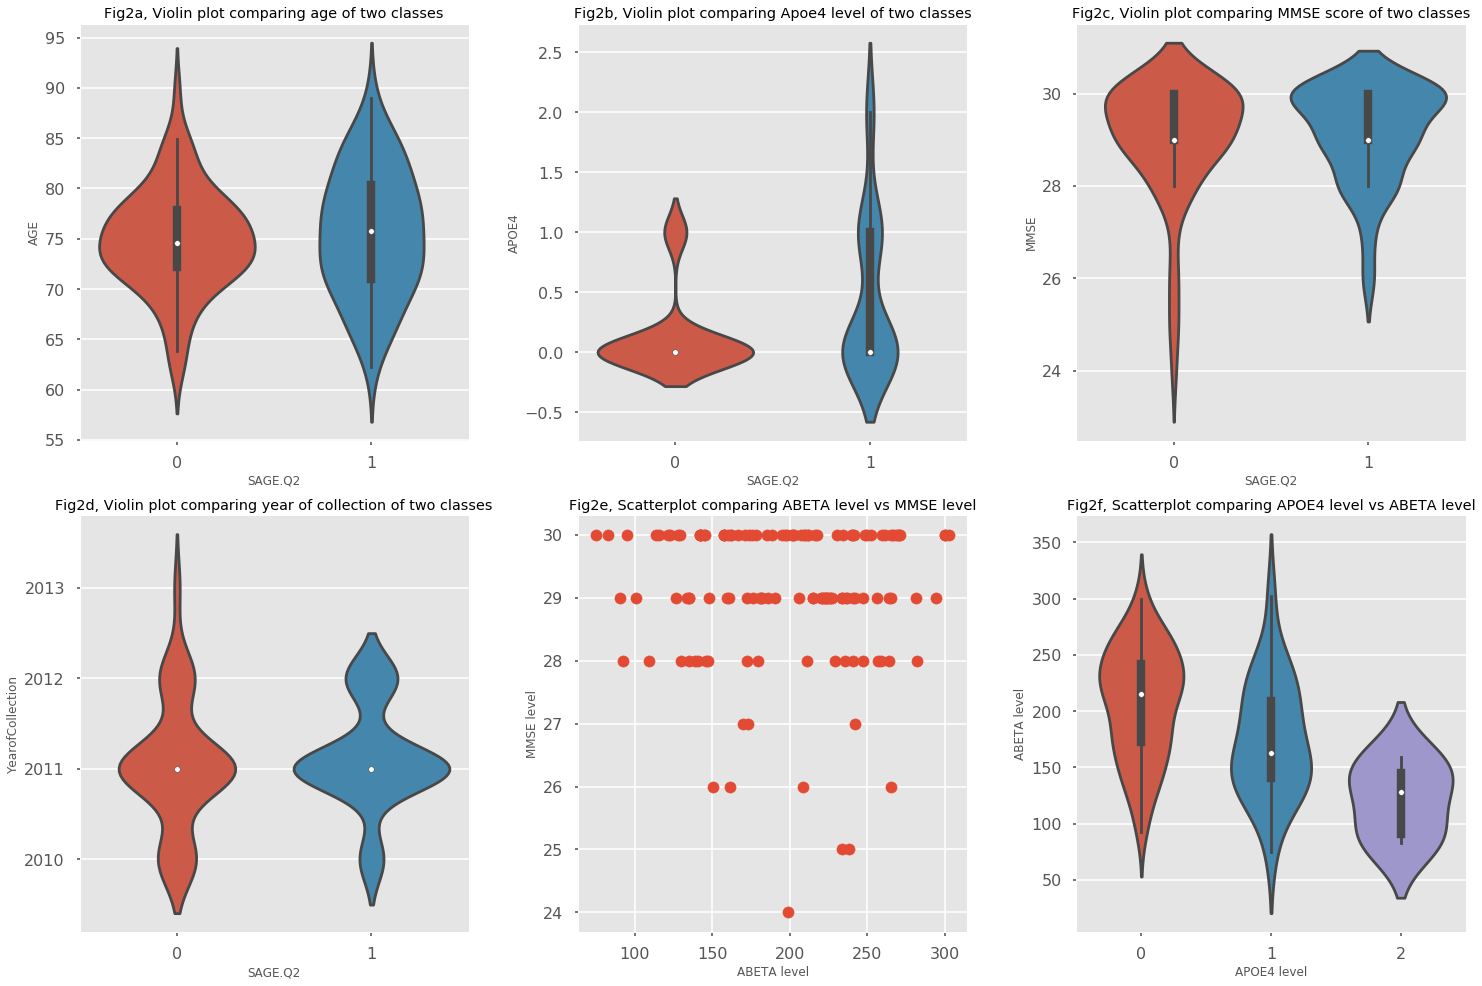

In [30]:
# Check distribution of amyloid-beta 42 level (ABETA) and class (SAGE.Q2)
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(21,15))
sns.violinplot(data_common['SAGE.Q2'], data_common['AGE'], ax=axes[0,0])
axes[0,0].set_title("Fig2a, Violin plot comparing age of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common['APOE4'], ax=axes[0,1])
axes[0,1].set_title("Fig2b, Violin plot comparing Apoe4 level of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common['MMSE'], ax=axes[0,2])
axes[0,2].set_title("Fig2c, Violin plot comparing MMSE score of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common.YearofCollection.convert_objects(convert_numeric=True), ax=axes[1,0])
axes[1,0].set_title("Fig2d, Violin plot comparing year of collection of two classes")

axes[1,1].scatter(data_common['ABETA'],data_common['MMSE'])
axes[1,1].set_xlabel('ABETA level')
axes[1,1].set_ylabel('MMSE level')
axes[1,1].set_title("Fig2e, Scatterplot comparing ABETA level vs MMSE level")

sns.violinplot(data_common['APOE4'], data_common['ABETA'], ax=axes[1,2])
axes[1,2].set_ylabel('ABETA level')
axes[1,2].set_xlabel('APOE4 level')
axes[1,2].set_title("Fig2f, Scatterplot comparing APOE4 level vs ABETA level")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])